In [335]:
import pandas as pd
import numpy as np

#gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import gensim.corpora as corpora
from gensim.models import CoherenceModel

#nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem import wordnet
import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [336]:
st_df = pd.read_pickle('../data/st_trails_df_2')
st_df_with_desc = st_df[st_df['description_length']>=40]
X = st_df_with_desc['description']
documents = X

In [414]:
from gensim.parsing.preprocessing import STOPWORDS
from nltk.corpus import stopwords

not_stops_firstpass = ['not', 'bottom', 'few', 'many', 'more', 'less', 'most', 'least', 'never', 'off', 'out'\
                           'very', 'too', 'overly', 'so']
new_stops_firstpass = ['br']
first_stopwords = (STOPWORDS.difference(not_stops_firstpass)).union(new_stops_firstpass)

In [415]:
def tokenize(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        result.append(token)
    return result

def remove_stopwords_firstpass(tokenized_text):
    result = []
    for word in tokenized_text:
        if word not in first_stopwords:
            result.append(word)
    return result

tokenized_docs = documents.map(tokenize)
tokenized_docs[:10]
tokenized_nostops = tokenized_docs.map(remove_stopwords_firstpass)
tokenized_nostops[:10]

0    [mcdonald, dunn, forest, offers, incredible, v...
1    [ride, north, left, intersection, run, creeks,...
2    [trail, starts, far, bridge, parking, lot, goe...
3    [description, description, north, south, trail...
4    [rides, hardy, creek, trail, head, deerskull, ...
5    [good, ride, beginer, mt, cross, bike, good, s...
6    [miles, lava, field, making, toughest, picnic,...
7    [blackrock, mountain, bike, trail, wooden, dir...
8    [trailhead, right, campground, outhouse, trail...
9    [recomend, noth, ridge, good, hill, careful, c...
Name: description, dtype: object

In [497]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

sent_stream = tokenized_nostops

bigram = Phrases(sent_stream, min_count=5, threshold=2)
# bigram.export_phrases(sent_stream)
bigram_phraser = Phraser(bigram)

def bigramize(text):
    return bigram_phraser[text]

bigrams = tokenized_nostops.map(bigramize)
trigram = Phrases(bigrams, min_count=5, threshold=2)
trigram_phraser = Phraser(trigram)

def trigramize(text):
    return trigram_phraser[text]

trigrams = bigrams.map(trigramize)
type(trigrams[0])

list

In [479]:
my_stopwords = set(['climb', 'mountain', 'road', 'singletrack', 'loop', 'trail', 'trails',  'ride', 'area', 'route', 'way', \
                    'feature', 'section','sections', 'riding', \
                'loop','br', 'mile', 'miles', 'right', 'left', 'www', 'http', 'https', 'bike', 'bikes', 'bicycle', 'bicycles', \
                'continue', 'rider', 'riders', 'parking', 'lot', 'turn', 'start', 'starts', 'description', 'cross', \
                'north', 'south', 'east', 'west', '-PRON-', 'pron', 'nee', 'regard', 'shall', 'use', 'win', \
                   'park', 'point', 'biking', 'follow', 'single', 'track', 'intersection', 'trailhead', 'head', \
                   'good', 'great', 'nice', 'time', 'include', 'place', 'come', 'downhill', 'look', 'near'])
bitri_stops = set(['parking_lot', 'trail_starts', 'mile_turn', 'north_south', 'mountain_bike', 'mountain_biking', 'single_track', \
                  'mountain_bike_trail', 'trail_head'])
all_stopwords = my_stopwords.union(STOPWORDS).union(bitri_stops)

In [499]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].lower()
    tag_dict = {'j': 'a',
            'n': 'n',
            'v': 'v',
            'r': 'r'}
    return tag_dict.get(tag, 'n')


def lemmatize_(text):
    pos = get_wordnet_pos(text)
    return WordNetLemmatizer().lemmatize(text, pos=pos)

def preprocess(text):
    result = []
    for token in text:
        if (token not in all_stopwords) and (len(token) > 3):
            lem = lemmatize_(token)
            if lem not in all_stopwords:
                result.append(lem)
    return result

In [500]:
processed_docs = trigrams.map(preprocess)

In [502]:
processed_docs[3]

['saddle',
 'forest',
 'limited',
 'view',
 'ridge',
 'wonderful',
 'view',
 'trail_follows',
 'ridge',
 'line',
 'base',
 'sunrise',
 'peak',
 'drop',
 'meadow',
 'pond',
 'ridge',
 'skirt',
 'juniper',
 'peak',
 'sunrise',
 'peak',
 'jumbo',
 'peak',
 'trail_ends',
 'dark',
 'meadow',
 'boundary',
 'improvement',
 'plan',
 'check',
 'randle',
 'district',
 'current',
 'information',
 'open',
 'ridgetop',
 'burn',
 'result',
 'beautiful',
 'meadow',
 'ridge',
 'today',
 'more_difficult',
 'sheepherder',
 'stock',
 'driveway',
 'water',
 'trough',
 'jumbo',
 'peak',
 'motorize']

In [483]:
#create dictionary
id2word = gensim.corpora.Dictionary(processed_docs)
id2word.filter_extremes(no_below=3, no_above=0.6, keep_n=10000, keep_tokens=None)

#create corpus
texts = processed_docs 

#Term Document Frequency
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [484]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=id2word, passes=2, workers=2)

In [498]:
from pprint import pprint

# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.017*"creek" + 0.010*"rock" + 0.008*"valley" + 0.007*"river" + '
  '0.007*"foot" + 0.006*"view" + 0.006*"hill" + 0.006*"steep" + '
  '0.006*"slickrock" + 0.006*"rocky"'),
 (1,
  '0.008*"creek" + 0.007*"begin" + 0.007*"ridge" + 0.007*"fast" + 0.006*"rock" '
  '+ 0.006*"small" + 0.006*"hill" + 0.006*"easy" + 0.006*"technical" + '
  '0.005*"long"'),
 (2,
  '0.011*"little" + 0.010*"foot" + 0.007*"long" + 0.006*"rock" + 0.006*"creek" '
  '+ 0.006*"technical" + 0.006*"best" + 0.006*"short" + 0.005*"hill" + '
  '0.005*"dirt"'),
 (3,
  '0.010*"lake" + 0.009*"ridge" + 0.007*"river" + 0.007*"little" + '
  '0.007*"offer" + 0.006*"technical" + 0.006*"view" + 0.006*"hill" + '
  '0.006*"pas" + 0.005*"open"'),
 (4,
  '0.015*"hill" + 0.010*"easy" + 0.010*"ridge" + 0.009*"technical" + '
  '0.007*"bridge" + 0.007*"rock" + 0.007*"lake" + 0.006*"forest" + '
  '0.006*"short" + 0.005*"steep"')]


In [486]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.37582067364634

Coherence Score:  0.30578956319080897


In [489]:
# Trying out different values for number of topics
num_topics = np.arange(2, 20, 2)

perplexities = []
coherences = []

for k in num_topics:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=k, id2word=id2word, passes=2, workers=2)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

Text(0.5,1,'Coherence vs. Number of Topics')

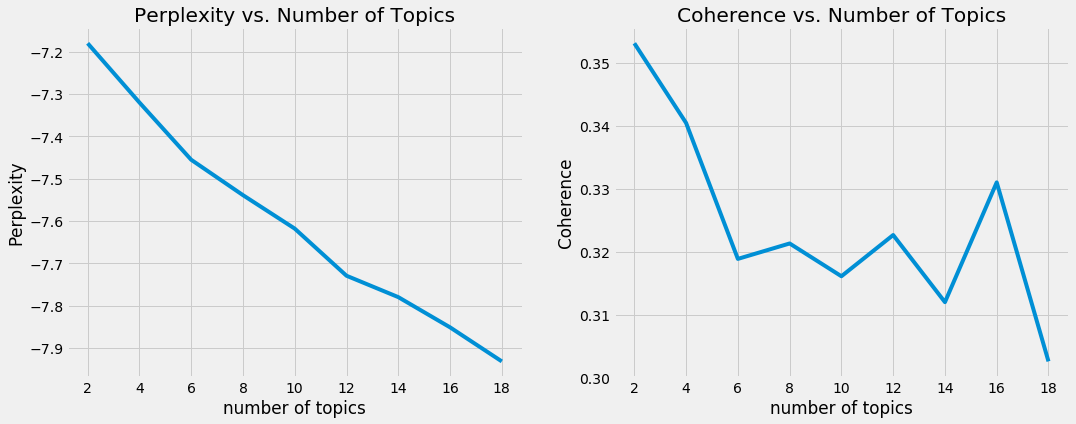

In [490]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(num_topics, perplexities)
axs[0].set_xlabel('number of topics')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Number of Topics')
axs[1].plot(num_topics, coherences)
axs[1].set_xlabel('number of topics')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Number of Topics')

In [170]:
# Trying out different values for alpha (document-topic-prior)
alphas = np.arange(0.1, 1, 0.1)

perplexities = []
coherences = []

for a in alphas:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2, alpha=a)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

Text(0.5,1,'Coherence vs. Alpha')

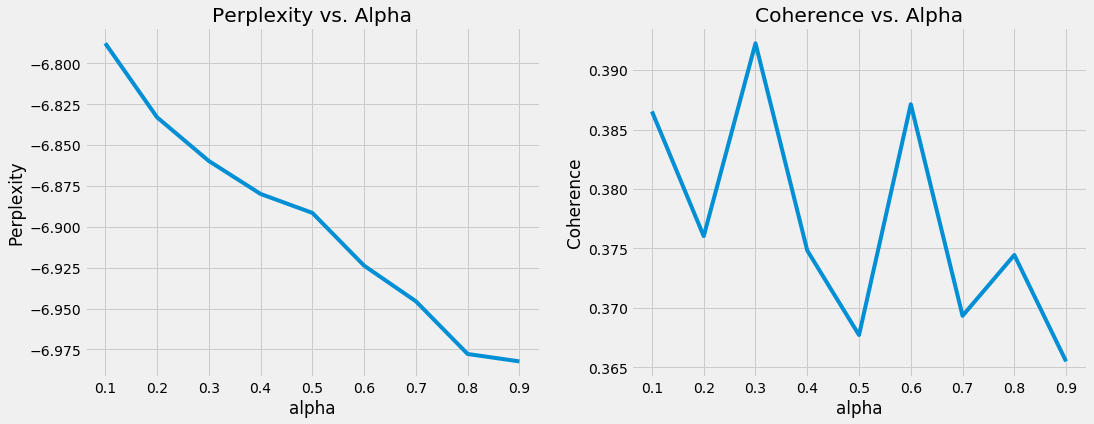

In [171]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(alphas, perplexities)
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Alpha')
axs[1].plot(alphas, coherences)
axs[1].set_xlabel('alpha')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Alpha')


In [172]:
# Trying out different values for eta (topic-word-prior)
etas = np.arange(0.1, 1, 0.1)

perplexities = []
coherences = []

for e in etas:
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=id2word, passes=2, workers=2, alpha=0.6, eta=e)
    perplexity = lda_model.log_perplexity(bow_corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    perplexities.append(perplexity)
    coherences.append(coherence_lda)

Text(0.5,1,'Coherence vs. Eta')

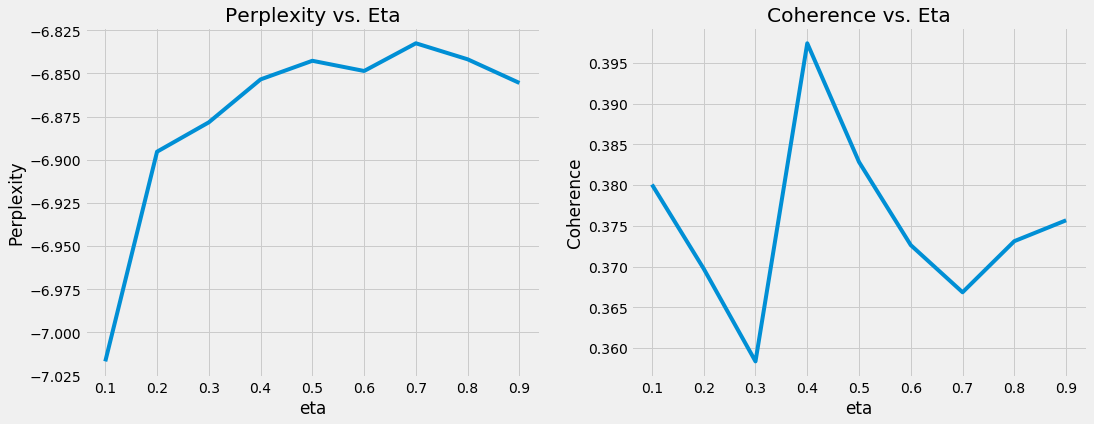

In [173]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(etas, perplexities)
axs[0].set_xlabel('eta')
axs[0].set_ylabel('Perplexity')
axs[0].set_title('Perplexity vs. Eta')
axs[1].plot(etas, coherences)
axs[1].set_xlabel('eta')
axs[1].set_ylabel('Coherence')
axs[1].set_title('Coherence vs. Eta')


In [494]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=id2word, passes=2, workers=2)

In [495]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.008733 -0.020810       1        1  25.451548
3      0.017785 -0.019505       2        1  23.283773
4      0.007689 -0.041821       3        1  19.932117
0      0.052098  0.050777       4        1  17.823219
2     -0.068839  0.031358       5        1  13.509343, topic_info=     Category        Freq       Term       Total  loglift  logprob
44    Default  174.000000      creek  174.000000  30.0000  30.0000
476   Default   90.000000       foot   90.000000  29.0000  29.0000
79    Default  113.000000     little  113.000000  28.0000  28.0000
1076  Default   45.000000  slickrock   45.000000  27.0000  27.0000
133   Default  177.000000       hill  177.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
295    Topic5    9.894660       flow   53.363239   0.3167  -5.7356
123    Topic5   12.015128       view  108.085625  -0.1950  -5.5414
53     Topic5   11.273569     bridge   95.700645  -0.1370  -5.6051
9      Topic5   10.711979       fast   87.421432  -0.0976  -5.6562
130    Topic5   10.434522      steep  107.715034  -0.3326  -5.6825

[387 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
391       1  0.188591  access
391       2  0.348168  access
391       3  0.217605  access
391       4  0.145070  access
391       5  0.101549  access
...     ...       ...     ...
98        1  0.221478   worth
98        2  0.158198   worth
98        3  0.126559   worth
98        4  0.158198   worth
98        5  0.316397   worth

[982 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 1, 3])